In [1517]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#Метрики
from sklearn.metrics import mean_absolute_error


from sklearn.dummy import DummyRegressor
#from imblearn.pipeline import make_pipeline
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [1518]:
#Изменим настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

RS = 32715

## Анализ датасета

In [1519]:
df_train_orig = pd.read_csv('data/train_dataset.csv',  parse_dates=[0])
df_test_orig = pd.read_csv('data/test_dataset.csv',  parse_dates=[0])

In [1520]:
#Функция для возврата часа в дату
def date_plus_hours_to_index(data):
    data = data.copy()
    data['date'] = data['date'] + pd.to_timedelta(data['time'] , 'H')
    data = data.set_index('date')
    return data

In [1521]:
df_train = date_plus_hours_to_index(df_train_orig)
df_test = date_plus_hours_to_index(df_test_orig)

In [1522]:
# Поменяем порядок двух первых столбцов
column_names = list(df_train)
column_names[0], column_names[1] = column_names[1], column_names[0]
df_train = df_train.loc[:, column_names]

column_names = list(df_test)
column_names[0], column_names[1] = column_names[1], column_names[0]
df_test = df_test.loc[:, column_names]

In [1523]:
print(f'Значения индекса монотонны: {df_train_orig.index.is_monotonic_increasing}')
df_train

Значения индекса монотонны: True


,target,time,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,481.51,0,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,462.872,1,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,449.718,2,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,430.908,3,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,415.163,4,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31 19:00:00,552.96,19,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 20:00:00,563.985,20,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 21:00:00,560.191,21,6.3,5.0,"пасм, 61%","пасм, дымка"


In [1524]:
print(f'Значения индекса монотонны: {df_test_orig.index.is_monotonic_increasing}')
df_test

Значения индекса монотонны: True


,target,time,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01 00:00:00,479.282,0,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,445.182,1,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,424.225,2,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,413.866,3,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,408.146,4,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31 19:00:00,453.173,19,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 20:00:00,446.287,20,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 21:00:00,444.373,21,15.8,17.0,"пасм, 24% дождь",п/обл


### Первичный анализ

In [1525]:
#список признаков, по которым функция анализа не будет строить гистограммы
exception_list = ['weather_pred', 'weather_fact', 'time']

##### [Funct] Функция для первичного анализа

In [1526]:
def data_analyse(data, exception_list = []):
    list_c = data.columns.unique()
    temp = data.copy()
    print(temp.info())
    print('-'* 25)
    if temp.duplicated().sum() == 0:
        print(f'Явных дубликатов нет')
    else:
        print(f'Количество явных дубликатов в датасете:{temp.duplicated().sum()}')
    for col_l in list_c:
        uniq_count = temp[col_l].nunique()
        print('-'* 25)
        print(f'{col_l}')
        print('Уникальные значения')
        print(f'Первые 5 значений: {temp[col_l].sort_values().head(5).unique()}')
        print(f'Последние 5 значений: {temp[col_l].sort_values(ascending = False).head(5).unique()}')
        print(f'Количество уникальных значений: {uniq_count},        процент уникальных значений: {round(uniq_count/len(temp)*100, 2)}%')
        print(f'Количество нулевых значений: {temp[(temp[col_l] == 0) | (temp[col_l] == 0.0)][col_l].count()},        процент нулевых значений: {round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2)}%')
        print(f'Количество пропущенных значений: {temp[col_l].isna().sum()},        процент пропущенных значений:{round(temp[col_l].isna().sum()/len(temp)*100, 2)}%')
        if col_l not in exception_list:
            data[col_l].hist(bins = 100)
            plt.title(col_l)
            plt.show()
    try:
        plt.figure(figsize=(8,8), dpi= 80)
        sns.heatmap(data.corr(),  cmap='Purples', center=0, annot=True)
        plt.title('Зависимость признаков')
        plt.show()
    except:
        print('Коррелирующих признаков нет')
    display(data)
    display(data.describe().round(3))  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        37224 non-null  float64
 1   time          37224 non-null  int64  
 2   temp          37224 non-null  float64
 3   temp_pred     37136 non-null  float64
 4   weather_pred  37136 non-null  object 
 5   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ MB
None
-------------------------
Явных дубликатов нет
-------------------------
target
Уникальные значения
Первые 5 значений: [198.982 202.698 207.881 209.047 209.798]
Последние 5 значений: [767.888 767.278 766.663 764.643 763.678]
Количество уникальных значений: 35327,        процент уникальных значений: 94.9%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 0,        процент пропущенных значени

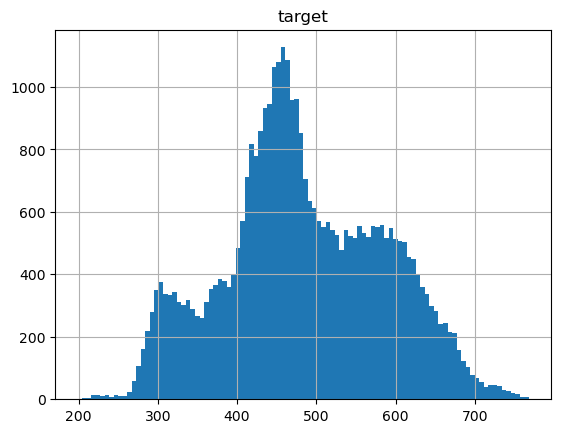

-------------------------
time
Уникальные значения
Первые 5 значений: [0]
Последние 5 значений: [23]
Количество уникальных значений: 24,        процент уникальных значений: 0.06%
Количество нулевых значений: 1551,        процент нулевых значений: 4.17%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
-------------------------
temp
Уникальные значения
Первые 5 значений: [-21.7 -20.9]
Последние 5 значений: [32.5 32.2]
Количество уникальных значений: 474,        процент уникальных значений: 1.27%
Количество нулевых значений: 171,        процент нулевых значений: 0.46%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


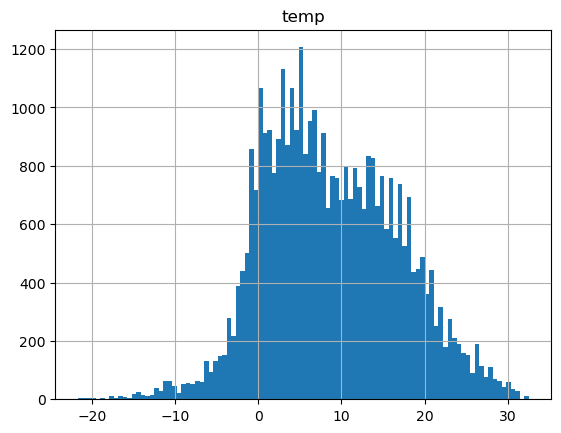

-------------------------
temp_pred
Уникальные значения
Первые 5 значений: [-20. -19.]
Последние 5 значений: [33. 32.]
Количество уникальных значений: 54,        процент уникальных значений: 0.15%
Количество нулевых значений: 1506,        процент нулевых значений: 4.05%
Количество пропущенных значений: 88,        процент пропущенных значений:0.24%


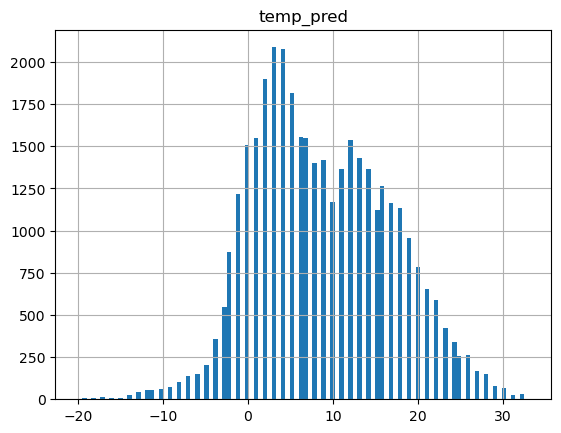

-------------------------
weather_pred
Уникальные значения
Первые 5 значений: [' п/обл, 35% дождь']
Последние 5 значений: ['ясно,ветер']
Количество уникальных значений: 2181,        процент уникальных значений: 5.86%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 88,        процент пропущенных значений:0.24%
-------------------------
weather_fact
Уникальные значения
Первые 5 значений: [' обл, ветер']
Последние 5 значений: ['ясно,ветерок']
Количество уникальных значений: 580,        процент уникальных значений: 1.56%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 1,        процент пропущенных значений:0.0%
Коррелирующих признаков нет


,target,time,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,481.51,0,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,462.872,1,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,449.718,2,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,430.908,3,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,415.163,4,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31 19:00:00,552.96,19,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 20:00:00,563.985,20,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 21:00:00,560.191,21,6.3,5.0,"пасм, 61%","пасм, дымка"


,target,time,temp,temp_pred
count,37224.0,37224.0,37224.0,37136.0
mean,483.731,11.5,8.749,8.769
std,101.459,6.922,8.126,8.018
min,198.982,0.0,-21.7,-20.0
25%,418.951,5.75,2.6,3.0
50%,473.064,11.5,7.9,8.0
75%,561.217,17.25,14.7,15.0
max,767.888,23.0,32.5,33.0


<Figure size 640x640 with 0 Axes>

In [1527]:
data_analyse(df_train, exception_list)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 00:00:00 to 2023-07-31 23:00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        2928 non-null   float64
 1   time          2928 non-null   int64  
 2   temp          2928 non-null   float64
 3   temp_pred     2904 non-null   float64
 4   weather_pred  2904 non-null   object 
 5   weather_fact  2928 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 160.1+ KB
None
-------------------------
Явных дубликатов нет
-------------------------
target
Уникальные значения
Первые 5 значений: [264.819 268.716 270.401 272.039 272.483]
Последние 5 значений: [607.474 607.312 606.805 606.014 604.161]
Количество уникальных значений: 2905,        процент уникальных значений: 99.21%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 0,        процент пропущенных значен

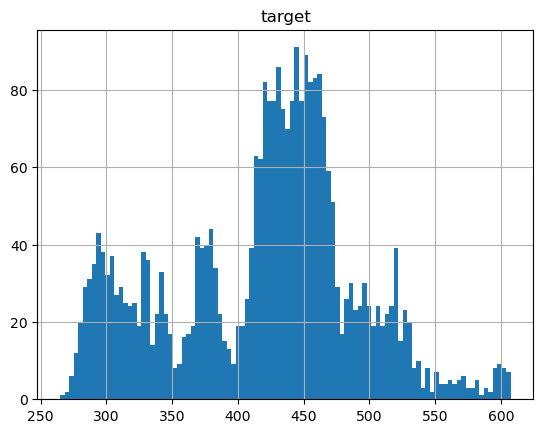

-------------------------
time
Уникальные значения
Первые 5 значений: [0]
Последние 5 значений: [23]
Количество уникальных значений: 24,        процент уникальных значений: 0.82%
Количество нулевых значений: 122,        процент нулевых значений: 4.17%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
-------------------------
temp
Уникальные значения
Первые 5 значений: [-3.1 -2.9]
Последние 5 значений: [31.7 30.6]
Количество уникальных значений: 270,        процент уникальных значений: 9.22%
Количество нулевых значений: 3,        процент нулевых значений: 0.1%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


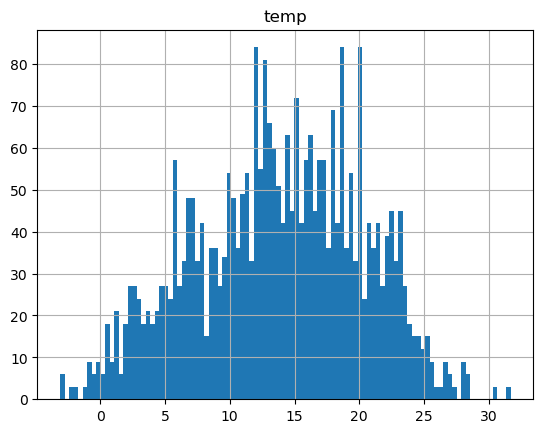

-------------------------
temp_pred
Уникальные значения
Первые 5 значений: [-3.]
Последние 5 значений: [29.]
Количество уникальных значений: 32,        процент уникальных значений: 1.09%
Количество нулевых значений: 54,        процент нулевых значений: 1.84%
Количество пропущенных значений: 24,        процент пропущенных значений:0.82%


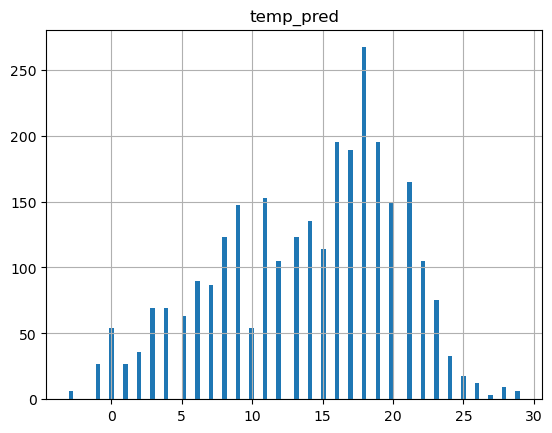

-------------------------
weather_pred
Уникальные значения
Первые 5 значений: ['0']
Последние 5 значений: ['ясно, юго-зап.ветер' 'ясно, штиль']
Количество уникальных значений: 246,        процент уникальных значений: 8.4%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 24,        процент пропущенных значений:0.82%
-------------------------
weather_fact
Уникальные значения
Первые 5 значений: ['дождь']
Последние 5 значений: ['ясно, хол.ветерок']
Количество уникальных значений: 121,        процент уникальных значений: 4.13%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
Коррелирующих признаков нет


,target,time,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01 00:00:00,479.282,0,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,445.182,1,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,424.225,2,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,413.866,3,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,408.146,4,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31 19:00:00,453.173,19,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 20:00:00,446.287,20,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 21:00:00,444.373,21,15.8,17.0,"пасм, 24% дождь",п/обл


,target,time,temp,temp_pred
count,2928.0,2928.0,2928.0,2904.0
mean,419.467,11.5,13.769,13.91
std,71.393,6.923,6.48,6.382
min,264.819,0.0,-3.1,-3.0
25%,371.384,5.75,9.2,9.0
50%,431.477,11.5,14.0,15.0
75%,462.414,17.25,18.7,19.0
max,607.474,23.0,31.7,29.0


<Figure size 640x640 with 0 Axes>

In [1528]:
data_analyse(df_test, exception_list)

In [1529]:
#Посмотрим на динамику среднего значения и среднеквадратичного отклонения в разрезе 30 и 160 дней
def data_std_mean(data, count_rollin):
    data_copy = data.copy()
    data_copy.sort_index(inplace=True)
    data_copy = data_copy.resample('1D').sum() 
    data_copy['mean'] = data_copy['target'].rolling(count_rollin).mean()
    data_copy['std'] = data_copy['target'].rolling(count_rollin).std()
    
    plt.figure(figsize=(20, 6))
    plt.subplot(312)
    data_copy[['target', 'mean', 'std']].plot(ax=plt.gca())
    plt.show()

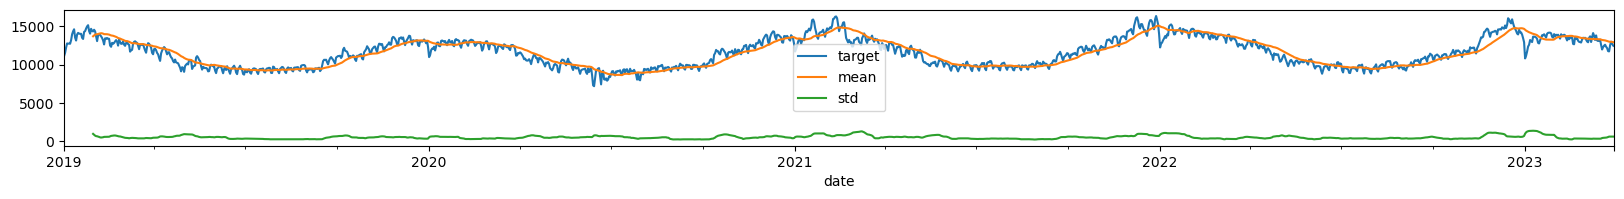

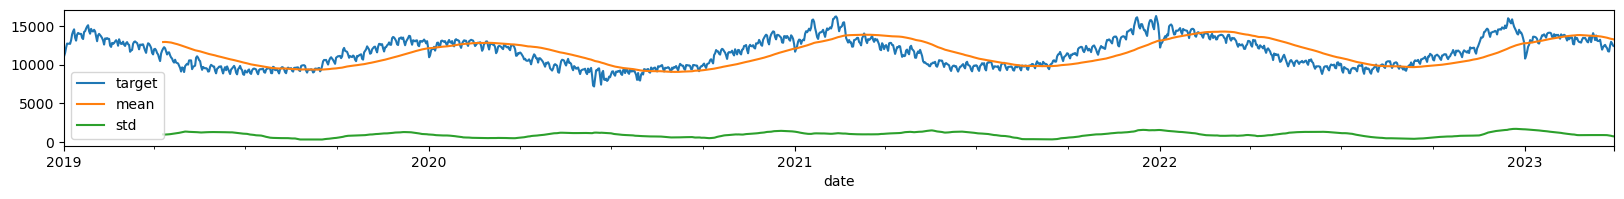

In [1530]:
data_std_mean(df_train, 30)
data_std_mean(df_train, 100)

#### Тест Дики-Фуллера на стационарность

In [1531]:
ts = df_train['target']
st_test = adfuller(ts, regression = 'ctt')
print('ADF Statistic: %f' % st_test[0])
print('p-value: %f' % st_test[1])
print('Critical Values:')
for key, value in st_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.572233
p-value: 0.005070
Critical Values:
	1%: -4.371
	5%: -3.833
	10%: -3.553


Исходя из полученных результатов, мы можем сделать вывод, что данные являются стационарными. Это означает, что они не имеют тренда или сезонности, и статистические характеристики данных могут быть считаны как постоянные с течением времени. p.s. Но это просто для полноты картины

<b>Сезонность и Тренд

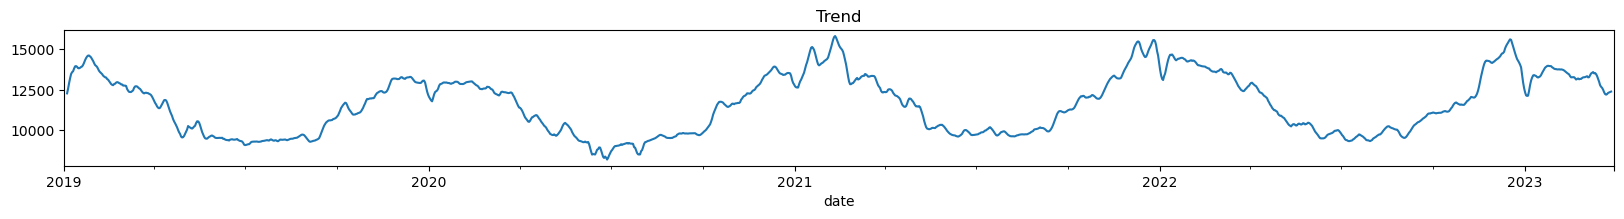

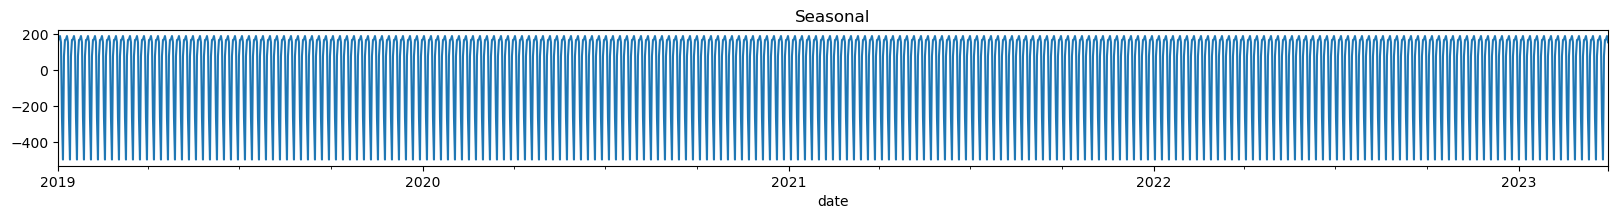

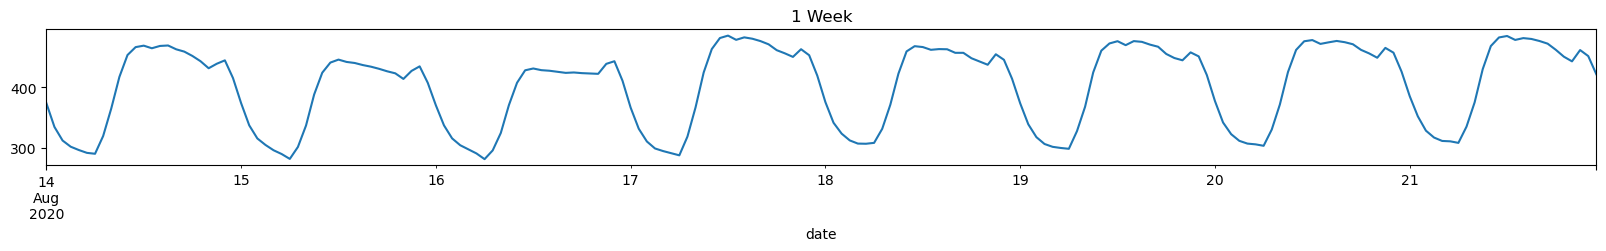

In [1532]:
df = df_train['target'].resample('1D').sum() 
decomposed = seasonal_decompose(df) 
# Тренд
plt.figure(figsize=(20, 6))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()
#Сезонность
plt.figure(figsize=(20, 6))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.show()
#1 Неделя
plt.figure(figsize=(20, 6))
plt.subplot(313)
df_train.loc['2020-08-14':'2020-08-21', 'target'].plot(ax=plt.gca())
plt.title('1 Week')
plt.show()

In [1533]:
df_train.head()

,target,time,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,481.51,0,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,462.872,1,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,449.718,2,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,430.908,3,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,415.163,4,4.3,2.0,"пасм, ветер","ветер, пасм"


In [1534]:
# Функция дополнения датасета временными лагами и скользящими средними (сутки, неделя, месяц)
def make_features(df, timeshift=24, max_lag=672, rolling_mean_size=[24, 168, 672], target='target'):
    new_df = df.copy()
#     data['year'] = data.index.year
    new_df['month'] = new_df.index.month
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek
    
    for lag in range(timeshift, max_lag + timeshift-1, timeshift):
        new_df['lag_{}'.format(lag)] = new_df[target].shift(lag)

    for size in rolling_mean_size:
        new_df['roll_mean_{}'.format(size)] = new_df[target].shift(timeshift).rolling(size).mean()
  
#    new_df = new_df.dropna()
    
    return new_df

In [1535]:
# Функция сдвига фактических данных температуры и погоды на одни сутки
def shift_features_fact(df, timeshift=24, list_fact_columns=['temp', 'weather_fact']):
    new_df = df.copy()
    for column in list_fact_columns:
        new_df[column] = new_df[column].shift(timeshift)
    
    return new_df

In [1536]:
df_train = make_features(df_train, timeshift=24, max_lag=168, rolling_mean_size=[24, 168])
df_train = shift_features_fact(df_train)
df_train = df_train.dropna()

In [1537]:
df_train.head()

,target,time,temp,temp_pred,weather_pred,weather_fact,month,day,dayofweek,lag_24,lag_48,lag_72,lag_96,lag_120,lag_144,lag_168,roll_mean_24,roll_mean_168
date,,,,,,,,,,,,,,,,,,
2019-01-08 23:00:00,565.146,23,-0.1,1.0,"пасм, 50% дождь",пасмурно,1,8,1,549.779,550.543,549.747,546.439,538.755,508.758,492.8,529.9972916666667,511.14394642857144
2019-01-09 00:00:00,526.586,0,-0.4,1.0,"обл, 45% снег","пасм, снег",1,9,2,517.676,523.761,518.851,514.853,506.119,479.831,465.381,529.74375,511.35922023809525
2019-01-09 01:00:00,490.225,1,-0.4,1.0,"обл, 45% снег","пасм, снег",1,9,2,485.831,494.211,487.836,481.142,473.726,450.047,437.692,529.3945833333333,511.49588095238096
2019-01-09 02:00:00,462.781,2,-0.4,1.0,"обл, 45% снег","пасм, снег",1,9,2,461.959,470.672,463.039,454.754,449.395,428.649,416.416,529.0315416666666,511.568744047619
2019-01-09 03:00:00,451.526,3,-1.1,0.0,"обл, 45% снег","пасм, снег",1,9,2,449.592,455.73,446.956,440.151,435.532,415.287,401.808,528.7757916666667,511.6799583333333


In [1538]:
df_test = make_features(df_test, timeshift=24, max_lag=168, rolling_mean_size=[24, 168])
df_test = shift_features_fact(df_test)
df_test = df_test.dropna()

In [1539]:
df_test.head()

,target,time,temp,temp_pred,weather_pred,weather_fact,month,day,dayofweek,lag_24,lag_48,lag_72,lag_96,lag_120,lag_144,lag_168,roll_mean_24,roll_mean_168
date,,,,,,,,,,,,,,,,,,
2023-04-08 23:00:00,501.072,23,12.3,7.0,"пасм, 61% дождь",облачно,4,8,5,510.303,544.946,547.28,545.949,540.766,530.681,523.083,512.4775,525.7944642857143
2023-04-09 00:00:00,464.665,0,8.4,6.0,"пасм, 67% дождь",ясно,4,9,6,474.482,502.326,505.69,503.402,498.367,488.304,485.462,511.31733333333335,525.7658928571428
2023-04-09 01:00:00,431.057,1,8.4,6.0,"пасм, 67% дождь",ясно,4,9,6,440.319,465.584,469.97,468.83,466.464,450.367,453.605,510.26462499999997,525.7369464285714
2023-04-09 02:00:00,410.968,2,8.4,6.0,"пасм, 67% дождь",ясно,4,9,6,418.701,445.453,451.28,449.304,444.738,430.023,432.391,509.14995833333336,525.7040654761904
2023-04-09 03:00:00,398.749,3,7.5,5.0,"пасм, 12% дождь",ясно,4,9,6,408.229,436.457,442.839,440.147,437.845,420.24,420.61,507.9737916666666,525.670511904762


## Исследование глупой модели

В качестве глуппых предсказаний рассмотрим значения электропотребления за предыдущие сутки и скользящие средние.
Расчеты провоедем для двух вариантов временных рядов: по часам и семплированных по суткам.

Расчеты глупых предсказаний для исходного датасета (почасового):

In [1540]:
# Сделаем выборку необходимых столбцов
df_test_dummy = df_test[['target', 'lag_24', 'lag_168', 'roll_mean_24', 'roll_mean_168']]

In [1541]:
# Добавим данные за предыдущий год
df_test_dummy['2022'] = df_train['target'].loc['2022-04-08 23:00:00':'2022-07-30 23:00:00'].values

In [1542]:
# Расчитаем MAE для сравения таргета с таргетом за предыдущий день
df_diff = abs(df_test_dummy['target']-df_test_dummy['lag_24'])
df_diff = df_diff.resample('1D').sum()
df_diff = pd.DataFrame(df_diff.iloc[1:-1])
df_diff.mean()

0   276.3146194690265
dtype: float64

In [1543]:
# Расчитаем MAE для сравения таргета с таргетом за предыдущий день недели
df_diff_168 = abs(df_test_dummy['target']-df_test_dummy['lag_168'])
df_diff_168 = df_diff_168.resample('1D').sum()
df_diff_168 = pd.DataFrame(df_diff_168.iloc[1:-1])
df_diff_168.mean()

0   391.92715044247785
dtype: float64

In [1544]:
# Расчитаем MAE для сравения таргета с таргетом за предыдущий год
df_diff_year = abs(df_test_dummy['target']-df_test_dummy['2022'])
df_diff_year = df_diff_year.resample('1D').sum()
df_diff_year = pd.DataFrame(df_diff_year.iloc[1:-1])
df_diff_year.mean()

0   607.5064070796461
dtype: float64

In [1545]:
# Расчитаем MAE для сравения таргета с таргетом за предыдущий день
mean_absolute_error(df_test_dummy['target'],df_test_dummy['lag_24'])*24

280.9209730925175

In [1546]:
# Расчитаем MAE для сравения таргета с таргетом скользящих средних (сутки)
mean_absolute_error(df_test_dummy['target'],df_test_dummy['roll_mean_24'])*24

1289.4181249539254

In [1547]:
# Расчитаем MAE для сравения таргета с таргетом скользящих средних (неделя)
mean_absolute_error(df_test_dummy['target'],df_test_dummy['roll_mean_168'])*24

1288.087775630562

Расчеты глупых предсказаний для семплированного датасета:

In [1548]:
# Посуточно семплируем данные
df_mod_dummy = df_test['target'].resample('1D').sum()
df_mod_dummy = pd.DataFrame(df_mod.iloc[1:-1])

In [1549]:
df_mod_dummy.head()

,target,lag_1,roll_mean_7,roll_mean_30
date,,,,
2023-05-31,9451.778,9475.259,9326.326857142858,9873.159033333333
2023-06-01,9483.151,9451.778,9318.242857142857,9844.048700000001
2023-06-02,9341.364,9483.151,9327.940857142858,9794.179666666667
2023-06-03,9224.945,9341.364,9316.084142857144,9735.065866666668
2023-06-04,9080.638,9224.945,9330.745428571428,9672.480333333335


In [1550]:
# Сделаем выборку необходимых столбцов
df_mod_dummy = make_features(df_mod, timeshift=1, max_lag=8, rolling_mean_size=[7])
df_mod_dummy = df_mod[['target', 'lag_1', 'roll_mean_7']].dropna()

In [1551]:
# Расчитаем MAE для сравения таргета с таргетом за предыдущий день
mean_absolute_error(df_mod_dummy['target'],df_mod_dummy['lag_1'])

268.2763064516129

In [1552]:
# Расчитаем MAE для сравения таргета с таргетом скользящих средних (неделя)
mean_absolute_error(df_mod_dummy['target'],df_mod_dummy['roll_mean_7'])

405.6618617511523

In [1553]:
# Расчитаем MAE для сравения таргета с таргетом скользящих средних (месяц)
# mean_absolute_error(df_mod_dummy['target'],df_mod_dummy['roll_mean_30'])

## Обучение

In [1554]:
def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)

In [1555]:
# Разделим тренировочный датасет на выборки признаков и целевого признака
features_train = df_train.drop(['target', 'weather_pred', 'weather_fact'], axis=1)
target_train = df_train['target']

# Разделим тренировочный датасет на выборки признаков и целевого признака
features_test = df_test.drop(['target', 'weather_pred', 'weather_fact'], axis=1)
target_test = df_test['target']

In [1556]:
pipeline = make_pipeline()
pipeline.steps.append(('regression', DummyRegressor()))
pipeline

Pipeline(steps=[('regression', DummyRegressor())])

In [1557]:
# Посмотрим шаги пайплайна
pipeline.steps

[('regression', DummyRegressor())]

In [1558]:
def create_randomized_search_cv(pipeline, iterations_count, parameters=None):
    if parameters is None:
        params = [
            {
                'regression': [ElasticNet()],
                'regression__l1_ratio': [0, .25, .5, .75, 1],
                'regression__alpha': [.1, .5, 1, 5, 10]
            },
            {
                'regression': [RandomForestRegressor()],
                'regression__n_estimators': [10,50,100],
                'regression__max_depth': [5,10,20]
            },
            {
                'regression': [CatBoostRegressor(verbose=1)],
                'regression__n_estimators': [10,50,100],
                'regression__max_depth': [5,10,20]
            },
            {
                'regression': [LGBMRegressor(n_jobs=-1)],
                'regression__n_estimators': [10,50,100],
                'regression__max_depth': [5,10,20]
            }
        ]
    else:
        params = parameters

    grid = RandomizedSearchCV(pipeline,
                              params,
                              n_iter = iterations_count,
                              cv = TimeSeriesSplit(n_splits=4),
                              verbose = 1,
                              scoring = 'neg_mean_absolute_error',
                              n_jobs=-1,
                              random_state = RS)

    return grid

In [1559]:
grid = create_randomized_search_cv(pipeline, 30)

In [1560]:
%%time

grid.fit(features_train, target_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.577e+05, tolerance: 6.555e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Learning rate set to 0.5
0:	learn: 53.7097596	total: 79.6ms	remaining: 717ms
1:	learn: 33.1908633	total: 104ms	remaining: 416ms
2:	learn: 23.1519974	total: 178ms	remaining: 415ms
3:	learn: 18.8102554	total: 229ms	remaining: 343ms
4:	learn: 16.9242254	total: 274ms	remaining: 274ms
5:	learn: 15.7227044	total: 287ms	remaining: 191ms
6:	learn: 14.9733912	total: 298ms	remaining: 128ms
7:	learn: 14.4001119	total: 317ms	remaining: 79.3ms
8:	learn: 13.8312716	total: 343ms	remaining: 38.2ms
9:	learn: 12.9427547	total: 379ms	remaining: 0us


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e+06, tolerance: 1.349e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Learning rate set to 0.5
Learning rate set to 0.5
0:	learn: 53.8646518	total: 121ms	remaining: 1.09s
Learning rate set to 0.5
1:	learn: 33.5314985	total: 167ms	remaining: 667ms


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.779e+06, tolerance: 2.185e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.643e+06, tolerance: 3.036e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

0:	learn: 56.7749527	total: 109ms	remaining: 979ms
2:	learn: 23.6894960	total: 226ms	remaining: 528ms
0:	learn: 55.7281225	total: 92.7ms	remaining: 834ms
3:	learn: 19.5996810	total: 253ms	remaining: 379ms
1:	learn: 34.3998419	total: 215ms	remaining: 860ms
4:	learn: 17.6136837	total: 328ms	remaining: 328ms
1:	learn: 34.5514465	total: 178ms	remaining: 712ms
2:	learn: 24.0758310	total: 264ms	remaining: 616ms
5:	learn: 16.7184762	total: 381ms	remaining: 254ms
6:	learn: 15.8019173	total: 404ms	remaining: 173ms
2:	learn: 24.2593787	total: 265ms	remaining: 618ms
7:	learn: 15.3622753	total: 435ms	remaining: 109ms
3:	learn: 19.5164316	total: 370ms	remaining: 555ms
8:	learn: 14.9041455	total: 489ms	remaining: 54.4ms
3:	learn: 20.1154363	total: 348ms	remaining: 522ms
9:	learn: 14.2858845	total: 542ms	remaining: 0us
4:	learn: 18.2286154	total: 415ms	remaining: 415ms
4:	learn: 17.7284196	total: 463ms	remaining: 463ms
5:	learn: 16.7256946	total: 502ms	remaining: 335ms
5:	learn: 16.9980554	total: 553

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=Pipeline(steps=[('regression', DummyRegressor())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'regression': [ElasticNet()],
                                         'regression__alpha': [0.1, 0.5, 1, 5,
                                                               10],
                                         'regression__l1_ratio': [0, 0.25, 0.5,
                                                                  0.75, 1]},
                                        {'regression': [RandomForestRegressor()],
                                         'regress...
                                         'regression__n_estimators': [10, 50,
                                                                      100]},
                                        {'regression': [<catboost.core.CatBoostRegressor object at 0x7ff8cf033fd0>],
                                         'regression__max_depth': [5, 10, 20],
                                         'regression__n_estimators': [10, 50,
                                                                      100]},
                                        {'regression': [LGBMRegressor(max_depth=10,
                                                                      n_jobs=-1)],
                                         'regression__max_depth': [5, 10, 20],
                                         'regression__n_estimators': [10, 50,
                                                                      100]}],
                   random_state=32715, scoring='neg_mean_absolute_error',
                   verbose=1)

In [1561]:
# Посмотрим лучшиую модель и ее параметры
grid.best_params_

{'regression__n_estimators': 100,
 'regression__max_depth': 10,
 'regression': LGBMRegressor(max_depth=10, n_jobs=-1)}

In [1562]:
# Посмотрим получившуюся лучшую метрику MAE
abs(grid.best_score_)

10.09707162034318

## Тестирование

In [1563]:
%%time

predictions = pd.DataFrame(grid.predict(features_test), index=target_test.index)
predictions

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 55.5 ms, sys: 2.83 ms, total: 58.3 ms
Wall time: 6.37 ms


,0
date,
2023-04-08 23:00:00,499.7089105813718
2023-04-09 00:00:00,466.01416247901625
2023-04-09 01:00:00,431.6424002362923
2023-04-09 02:00:00,408.53512220261433
2023-04-09 03:00:00,401.8436185670577
...,...
2023-07-31 19:00:00,449.83439982494934
2023-07-31 20:00:00,444.2772540826754
2023-07-31 21:00:00,446.5769238529427


In [1564]:
mae = mean_absolute_error(target_test, predictions)
mae

8.089914084575307

In [1565]:
mae_day(target_test, predictions)

142.38053869862608

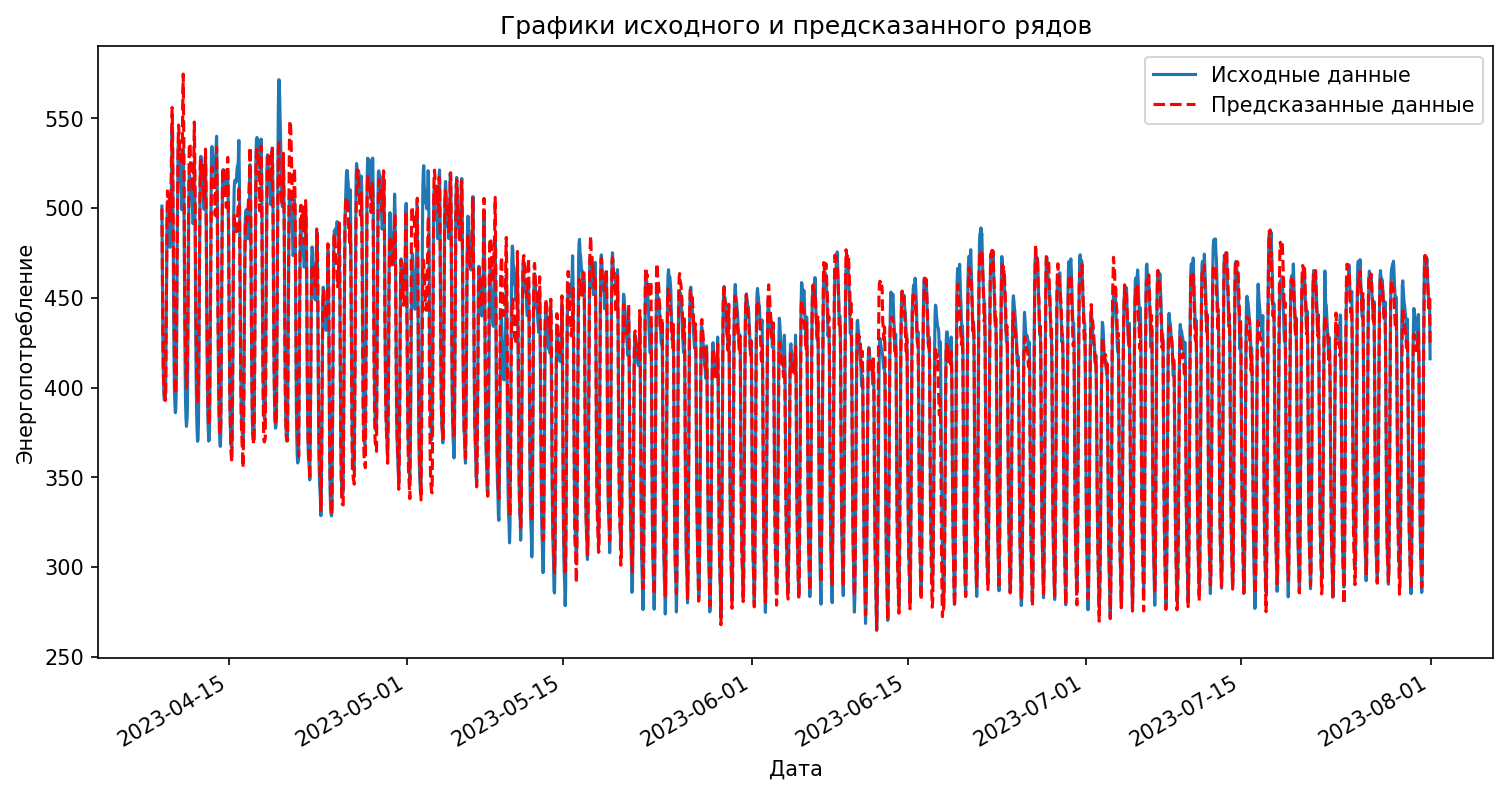

In [1566]:
# Визуализируем графики исходного и предсказанного рядов
plt.figure(figsize=(12,6), dpi=150)
target_test.plot(label='1')
predictions[0].plot(label='2',style='r--')
plt.title('Графики исходного и предсказанного рядов')
plt.ylabel('Энергопотребление')
plt.xlabel('Дата')
plt.legend(('Исходные данные', 'Предсказанные данные'))
plt.show()

## LSTM

In [1734]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [1743]:
%%time
mae_list = []
for _ in range(20):

    # Нормализуем данные в тренировочном и тестовом датасетах
    scaler = MinMaxScaler(feature_range=(0, 1))
    train = scaler.fit_transform(df_train.drop(['weather_pred', 'weather_fact'], axis=1))
    test = scaler.transform(df_test.drop(['weather_pred', 'weather_fact'], axis=1))

    # Разделим тренировочный датасет на массивы признаков и целевого признака
    trainX  = np.delete(train, 0, 1)
    trainY = train[:, 0]

    # Разделим тренировочный датасет на массивы признаков и целевого признака
    testX  = np.delete(test, 0, 1)
    testY = test[:, 0]

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # Создадим и обучим нейросеть
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, trainX.shape[2]), activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_absolute_error')
    model.fit(trainX, trainY, epochs=200, batch_size=2048, verbose=2, shuffle=False)

    # Сделаем прогноз для тренировочных и тестовых данных
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Выполним обратную нормализацию всех данных
    testX = testX.reshape(testX.shape[0], testX.shape[2])
    inv_testPredict = np.concatenate((testPredict, testX), axis=1)
    inv_testPredict = scaler.inverse_transform(inv_testPredict)

    trainX = trainX.reshape(trainX.shape[0], trainX.shape[2])
    inv_trainPredict = np.concatenate((trainPredict, trainX), axis=1)
    inv_trainPredict = scaler.inverse_transform(inv_trainPredict)

    inv_train = scaler.inverse_transform(train)
    inv_test = scaler.inverse_transform(test)

    # Посчитаем метрику MAE LSTM
    mae_list.append(mae_day(inv_test[:,0], inv_testPredict[:,0]))
print(mae_list, np.average(mae_list))

Epoch 1/200
19/19 - 1s - loss: 0.1980 - mean_absolute_error: 0.4109 - 898ms/epoch - 47ms/step
Epoch 2/200
19/19 - 0s - loss: 0.0317 - mean_absolute_error: 0.1405 - 69ms/epoch - 4ms/step
Epoch 3/200
19/19 - 0s - loss: 0.0110 - mean_absolute_error: 0.0865 - 73ms/epoch - 4ms/step
Epoch 4/200
19/19 - 0s - loss: 0.0063 - mean_absolute_error: 0.0638 - 69ms/epoch - 4ms/step
Epoch 5/200
19/19 - 0s - loss: 0.0048 - mean_absolute_error: 0.0554 - 70ms/epoch - 4ms/step
Epoch 6/200
19/19 - 0s - loss: 0.0036 - mean_absolute_error: 0.0481 - 68ms/epoch - 4ms/step
Epoch 7/200
19/19 - 0s - loss: 0.0028 - mean_absolute_error: 0.0423 - 70ms/epoch - 4ms/step
Epoch 8/200
19/19 - 0s - loss: 0.0022 - mean_absolute_error: 0.0371 - 68ms/epoch - 4ms/step
Epoch 9/200
19/19 - 0s - loss: 0.0020 - mean_absolute_error: 0.0344 - 71ms/epoch - 4ms/step
Epoch 10/200
19/19 - 0s - loss: 0.0018 - mean_absolute_error: 0.0328 - 70ms/epoch - 4ms/step
Epoch 11/200
19/19 - 0s - loss: 0.0017 - mean_absolute_error: 0.0317 - 68ms/e

In [1748]:
pd.DataFrame(mae_list).describe()

,0
count,20.0
mean,149.4778444633476
std,11.287036771795714
min,134.72755977218245
25%,142.92749701443924
50%,147.4886289419435
75%,151.85238492355785
max,173.11650988583804
